In [82]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../../results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","
import plotnine

from plotnine import *

# get param set
paramsets =  pd.read_csv('../../output_random_rows.csv')
paramsets = paramsets.drop(paramsets.columns.tolist()[-1],axis=1)

paramsets.drop('theta',inplace=True, axis=1)

df = pd.read_pickle("./pset3_allcell_A.pkl")  # cid, pSet, rr, 1 or 9

alltime = df['time'].unique()
df.columns=['cell'+str(cc) for cc in range(9)]+list(df.columns[9:])

In [83]:
dfcoord = pd.read_pickle('./pset3_allcell_Acoord.pkl')

In [84]:
dfwat = df.loc[df['vals']=='wat'].reset_index(drop=True).copy()
dfvol = df.loc[df['vals']=='vol'].reset_index(drop=True).copy()
dfcs = df.loc[df['vals']=='cs'].reset_index(drop=True).copy()
dfcl = df.loc[df['vals']=='cl'].reset_index(drop=True).copy() # 'coa', 'cod', 'cca', 'ccd', 'css', 'co2'
dfcoa = df.loc[df['vals']=='coa'].reset_index(drop=True).copy()
dfcod = df.loc[df['vals']=='cod'].reset_index(drop=True).copy()
dfcca = df.loc[df['vals']=='cca'].reset_index(drop=True).copy()
dfccd = df.loc[df['vals']=='ccd'].reset_index(drop=True).copy()
dfcss = df.loc[df['vals']=='css'].reset_index(drop=True).copy()
dfco2 = df.loc[df['vals']=='co2'].reset_index(drop=True).copy()

In [85]:
#get everything per volume of bulk soil -- scv
colvalsname = ['cell'+str(i) for i in range(9)]
dftheta = dfwat.copy()
dfcssoil = dfcs.copy()
dfclsoil = dfcl.copy()
dfccat = dfcca.copy()
dfcoat = dfcoa.copy()
dfcc =  dfcca.copy()
dfco =  dfcoa.copy()

dfcc[colvalsname] = dfcca[colvalsname] +  dfccd[colvalsname] 
dfco[colvalsname] = dfcoa[colvalsname] +  dfcod[colvalsname] 
dfccat[colvalsname] /= dfcc[colvalsname]
dfcoat[colvalsname] /= dfco[colvalsname]
dftheta[colvalsname] /= dfvol[colvalsname]
dfcssoil[colvalsname] *= dftheta[colvalsname]
dfclsoil[colvalsname] *= dftheta[colvalsname]

dftheta['vals']='theta'
dfcssoil['vals']='cssoil'
dfclsoil['vals']='clsoil'

In [86]:
dfsoc =  dfcoa.copy()
dfsoc[colvalsname] = dfcc[colvalsname] + dfco[colvalsname] + dfcssoil[colvalsname]+ dfclsoil[colvalsname] +dfcss[colvalsname]
dfcx = dfcc.copy()
dfcx[colvalsname] = dfcc[colvalsname] + dfco[colvalsname]

In [87]:
def getpartialQ(group, dfvol, dfcoord, r1):
    namekonz = group['vals'].values[0]
    print('namekonz',namekonz, end=', ')
    colvalsname = ['cell'+str(i) for i in range(9)]
    # r1 is beyond the outer boundary, so use the total solute content
    solute_content = np.zeros(group.shape[0])
    partial_volume =  np.zeros(group.shape[0])
    for cid in range(9):
        mask = (dfcoord['rOutS'+str(cid)] <= r1)# cell  complettelly bellow threshold
        if np.any(mask):
            solute_content[mask] += group.loc[mask,'cell'+str(cid)].values*dfvol.loc[mask,'cell'+str(cid)].values
            partial_volume[mask] += dfvol.loc[mask,'cell'+str(cid)].values

        mask = (dfcoord['rOutS'+str(cid)] > r1)&(dfcoord['rInS'+str(cid)] <= r1) # cell partly bellow threshold
        if np.any(mask):   
            dfcoordmask= dfcoord[mask].reset_index(drop=True).copy()
            groupmask = group[mask].reset_index(drop=True).copy()
            # Calculate contribution of the partially included cell at r1
            partial_start =dfcoordmask['rIn'+str(cid)].values
            partial_startS = dfcoordmask['rInS'+str(cid)].values
            # for vol computation  see ditance needed to add to go from rel to actual radius
            partial_start_diff =  dfcoordmask[ 'rIn0'].values
            partial_length = groupmask[ 'lens'].values 
            partial_volume_ = ((r1+partial_start_diff)**2 - partial_start**2) * partial_length * np.pi
            partial_volume[mask] += partial_volume_

            newCenter = (r1+dfcoordmask[ 'rInS'+str(cid)].values)/2 # new cell center to get new mean concentration value

            ratioDistance = ( newCenter-dfcoordmask[ 'cellS'+str(cid-1)].values)/( dfcoordmask['cellS'+str(cid)].values-dfcoordmask[ 'cellS'+str(cid-1)].values)
            partial_concentration = ratioDistance * groupmask['cell'+str(cid)].values + (1-ratioDistance)*groupmask['cell'+str(cid-1)].values
            maskr = newCenter >  dfcoordmask[ 'cellS'+str(cid)].values
            if cid < 8 :
                ratioDistance[maskr] = (( newCenter-dfcoordmask[ 'cellS'+str(cid)].values)/( dfcoordmask['cellS'+str(cid+1)].values-dfcoordmask['cellS'+str(cid)].values))[maskr]
                partial_concentration[maskr] =( ratioDistance * groupmask['cell'+str(cid+1)].values + (1-ratioDistance)*groupmask['cell'+str(cid)].values)[maskr]
                try:
                    assert ( (partial_concentration -  groupmask[['cell'+str(cid),'cell'+str(cid-1),'cell'+str(cid+1)]].values.max(axis=1) < 1e-16)&
                    (-partial_concentration + groupmask[['cell'+str(cid),'cell'+str(cid-1),'cell'+str(cid+1)]].values.min(axis=1) < 1e-16)).all()
                except:
                    err1 = (partial_concentration -  groupmask[['cell'+str(cid),'cell'+str(cid-1),'cell'+str(cid+1)]].values.max(axis=1) > 1e-16)
                    err2= (-partial_concentration + groupmask[['cell'+str(cid),'cell'+str(cid-1),'cell'+str(cid+1)]].values.min(axis=1) > 1e-16)
                    print('err1',partial_concentration[err1],groupmask[['cell'+str(cid),'cell'+str(cid-1),'cell'+str(cid+1)]].values.max(axis=1)[err1] )
                    print('err2',partial_concentration[err2],groupmask[['cell'+str(cid),'cell'+str(cid-1),'cell'+str(cid+1)]].values.min(axis=1)[err2] )
                    print((-partial_concentration + groupmask[['cell'+str(cid),'cell'+str(cid-1),'cell'+str(cid+1)]].values.min(axis=1))[err2])
                    raise Exception
            else:
                ratioDistance[maskr] =1
                partial_concentration[maskr] = groupmask['cell'+str(cid)].values[maskr]

                assert ( (partial_concentration -  groupmask[['cell'+str(cid),'cell'+str(cid-1)]].values.max(axis=1) < 1e-16)&
                    (-partial_concentration + groupmask[['cell'+str(cid),'cell'+str(cid-1)]].values.min(axis=1) < 1e-16)).all()

            solute_content[mask] += partial_concentration * partial_volume_
    return pd.DataFrame({
        #'cylId': group['locCylId'].iloc[0],
        'partialQ_'+namekonz: solute_content,
        'partial_volume': partial_volume,# soil scv
        'st': group['st'],
        'pSet': group['pSet'],
        'scenario': group['scenario'],
        'time': group['time'],
        'gId': group['gId']
    })


In [88]:

# Create a list to store results for different concentration ranges
results = []
obsDis = 0.06
for dftemp in [dftheta,dfcssoil,dfclsoil, dfcoa ,dfcod,dfcca,dfccd ,dfcss,dfco2]:
    result_df = getpartialQ(group=dftemp, dfvol=dfvol.copy(), dfcoord=dfcoord.copy(), r1=obsDis)
    results.append(result_df)


namekonz theta, namekonz cssoil, namekonz clsoil, namekonz coa, namekonz cod, namekonz cca, namekonz ccd, namekonz css, namekonz co2, 

In [89]:
from functools import reduce
# Columns to merge on
merge_columns = ['gId',  'pSet','st', 'partial_volume', 'time','scenario']

# Merge the DataFrames
merged_df = reduce(lambda left, right: pd.merge(left, right, on=merge_columns), results)
#merged_df.to_pickle('./allcellupto08mm.pkl')

In [90]:
merged_df.to_pickle('./pset3_06mm.pkl')

In [91]:


#outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
#column_names = outputvalsname + paramsets.columns.tolist()
def getnewval_cell(df):
    #outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
    #column_names = outputvalsname + paramsets.columns.tolist()
    for konzz in ['theta','coa','cod','cca','ccd','css','co2']:
        df[konzz] = df['partialQ_'+konzz]/df['partial_volume']
    for konzz in ['cs','cl']:
        df[konzz] = df['partialQ_'+konzz+'soil']/df['partialQ_theta']#/df['partial_volume']
    df['vols'] = df['partial_volume']
    df['wat'] = df['partialQ_theta']
    try:
        df['css']=df['css2']
    except:
        pass
    df['cxd']=df['cod']+df['ccd']
    df['cxa']=df['coa']+df['cca']
    df['co'] = df['cod']+df['coa']
    df['cc'] = df['ccd']+df['cca']
    df['cx']=df['co']+df['cc']
    df['cxd_cx']=df['cxd']/df['cx']
    df['cxa_cx']=df['cxa']/df['cx']
     

    try:
        df['theta']=df['wat']/df['vols']
    except:
        try:
            df['theta']=df['wat']/df['vol']
        except:
            pass
        pass
    #df  = pd.merge(df, paramsets[['pSet', 'theta_th']], on="pSet")
    #df['csBis'] = df['cs']*df['theta']/df['theta_th']
    #df['clBis'] = df['cl']*df['theta']/df['theta_th']
    # per unit of soil volume
    df['cs_'] = df['cs']*df['theta']
    df['cl_'] = df['cl']*df['theta']
    df['soc']=df['cs_']+df['css']+df['cl_']+df['cx'] # df['socinit']
    #df.loc[df['scenario'] == "earlyDry",'scenario']="earlyDry"  # Select subset where 'pSet' equals the current value
    
    solidDensity = 2650 # [kg/m^3 solid] #taken from google docs TraiRhizo
    solidMolarMass = 60.08e-3 # [kg/mol] 
    thetaS= 0.43
    mgC_per_molC=12.011*1000
    
    massBulkDensity = solidDensity*(1.- thetaS) *1000 /1e6 # [kg/m^3 scv] * [g/kg] * [m3/cm3] = g/cm3
    print('massBulkDensity',massBulkDensity)
    #df['pSet']=df['scenario']+'_'+df['pSet']

    bulkD = massBulkDensity# g/cm3 soil * kg/g
    MmassC = 12.011 # gC/molC
    clay = 0.178*1000 # g/g to g/kg
    SOCexp = (clay*0.0288+13.674) / MmassC * bulkD/1000  # g C / kg soil => mol C/cm3 soil
    SOCreal = 0.0112/MmassC *bulkD# g/g => molC/cm3 soil, https://acsess.onlinelibrary.wiley.com/doi/10.2136/vzj2017.08.0152

    initSOC  ={'5':0.000261564277948825, '44':0.0002941431464338718, '61':0.0002833083349901329} # obtained from simulation
    
    df['socinit'] = [initSOC[pipi] for pipi in df['pSet']]
    df['socadded'] = SOCreal - df['socinit']
    df['socadapted'] = df['socadded'] + df['soc']
    # mol/cm3 scv to mg C pool/g C mineral
    if False:
        for nnn in ['cs_','cl_','co','cc','coa','cod','cca','ccd','css']:
            # mol C/cm3 *  
            df[nnn+'_mass'] = df[nnn]*mgC_per_molC / massBulkDensity
    return df
dfmean = getnewval_cell(merged_df)
dfmean['pSetscenario']=np.char.add(np.array(dfmean['pSet'],dtype=str),np.array(dfmean['scenario'],dtype=str))

massBulkDensity 1.5105000000000002


In [92]:
dfsocadded = dfmean[['socadded', 'pSet', 'scenario']].drop_duplicates().reset_index(False) 
dfsocadded.to_pickle('./dfsocadded.pkl')

In [93]:

solidDensity = 2650 # [kg/m^3 solid] #taken from google docs TraiRhizo
solidMolarMass = 60.08e-3 # [kg/mol] 
thetaS= 0.43
mgC_per_molC=12.011*1000

massBulkDensity = solidDensity*(1.- thetaS) *1000 /1e6 # [kg/m^3 scv] * [g/kg] * [m3/cm3] = g/cm3
bulkD = massBulkDensity# g/cm3 soil * kg/g
MmassC = 12.011 # gC/molC
clay = 0.178*1000 # g/g to g/kg
SOCexp = (clay*0.0288+13.674) / MmassC * bulkD/1000  # g C / kg soil => mol C/cm3 soil
SOCreal = 0.0112/MmassC *bulkD# g/g => molC/cm3 soil, https://acsess.onlinelibrary.wiley.com/doi/10.2136/vzj2017.08.0152
print('massBulkDensity',massBulkDensity,SOCreal,SOCexp)
classesSOC = np.array([SOCreal,0.65*SOCexp,0.83*SOCexp,1.16*SOCexp]) # 

massBulkDensity 1.5105000000000002 0.0014085088668720342 0.002364333044709017


In [110]:
import string 
import matplotlib.ticker as mtick
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter

l_styles = {5:'-',44:'-.',61:':'}
# Define the color dictionary
c_styles = {
    'baseline':'#8da0cb',  # Blue
    'earlyDry':  '#66c2a5' ,  # Green
    'lateDry': '#fc8d62'  # red
}
color_legend_elements = [
    Line2D([0], [0], color=c_styles['baseline'], lw=5, label='baseline'),
    Line2D([0], [0], color=c_styles['earlyDry'], lw=5, label='earlyDry'),
    Line2D([0], [0], color=c_styles['lateDry'], lw=5, label='lateDry')
]

# Line style legend
linestyle_legend_elements = [
    Line2D([0], [0], color='black', linestyle=l_styles[5], lw=5, label=5),
    #Line2D([0], [0], color='black', linestyle=l_styles[38], lw=5, label=38),
    Line2D([0], [0], color='black', linestyle=l_styles[44], lw=5, label=44),
    Line2D([0], [0], color='black', linestyle=l_styles[61], lw=5, label=61)
]

def cumsum_(dataframe, independent_variable, dependent_variable, ascending):
    dataframe.sort_values([independent_variable], ascending=[ascending],inplace=True)
    dataframe['cumsum'] = np.cumsum(dataframe[dependent_variable].values)
    return dataframe[independent_variable], dataframe['cumsum']

def cumsum_and_plot(dataframe_, independent_variable, 
                    dependent_variable,time,ylab=None, xlab=None,
                    unitChange=1.,doTitle=True,
                     dorelative=False,doLog=False, ascending=True,
                    xlim=None,indexsubplotLegend=-1,
                   dosave=False, doshow=True, savedir='./',
                    saveName='myimage',commonLim=False,
                   vlines=[], ltypes_=[], maxYY=None,ax=None, fig=None,
                   indexsubplot=0, labelsnoYY=[]):
    for extraText in [savedir]:
        if not os.path.exists(extraText):
            os.makedirs(extraText)

    # Create the plot
    if ax is None:
        plt.figure(figsize=(8, 6))  # Adjust figure size if needed
        fillout = plt.gca()
    else:
        fillout = ax
    dataframe = dataframe_[dataframe_['time']==time].reset_index().copy()

    # Loop to plot each line
    for i in dataframe['pSetscenario'].unique():
        df__ =dataframe[dataframe['pSetscenario']==i].copy().reset_index()
        df_ = df__.groupby([independent_variable])[dependent_variable].agg('sum').reset_index()
        bin_means, bin_sums = cumsum_(df_, independent_variable, dependent_variable, ascending)
        vols_ =  bin_sums.values
        
        if dorelative:
            vols_ /= np.sum(df_['vols'])
        
        fillout.plot(bin_means.values*unitChange,vols_,
                                                             linewidth=3,
                         c=c_styles[df__['scenario'].unique()[0]],
                         linestyle=l_styles[int(df__['pSet'].unique()[0])])
    if commonLim:
        minXX = min(dataframe_[independent_variable])
        maxXX = max(dataframe_[independent_variable])
        fillout.set_xlim(minXX*unitChange,maxXX*unitChange)
        if not dorelative:
            fillout.set_ylim(0,maxYY)
    if xlim is not None:
        fillout.set_xlim(xlim[0]*unitChange,xlim[1]*unitChange)
        
    fillout.set_xlabel(xlab, fontsize=20)#'maximum '+independent_variable+' (mol/cm3 water)')
    fillout.set_ylabel(ylab, fontsize=20)
    fillout.tick_params(axis='both', which='major', labelsize=18)
    
    if doTitle:
        fillout.set_title(str(int(time*10)/10), fontsize=20)
    for vid, vine in enumerate(vlines):
        fillout.axvline(x=vine*unitChange, color='k', linestyle=ltypes_[vid])
        
    
    # Set x-axis to scientific format
    if unitChange <= 1.:
        fillout.tick_params(axis='x', which='major', labelrotation=30, labelsize=18)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        fillout.xaxis.set_major_formatter(formatter)
        fillout.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
        fillout.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2e}'))
    #plt.title(str(int(time*10)/10)+ "d", fontsize=20)
    if doLog:
        fillout.set_xscale('log')
    #plt.legend()
    if indexsubplot == indexsubplotLegend:
        color_legend = fillout.legend(handles=color_legend_elements, 
                   fontsize=20,title_fontsize='25', title='scenario', 
                   loc='center',  ncol=1, bbox_to_anchor=(0.3, 0.7))
        linestyle_legend = fillout.legend(handles=linestyle_legend_elements, 
                   fontsize=20,title_fontsize='25', title='parameter set', 
                   loc='center',  ncol=1, bbox_to_anchor=(0.3, 0.3))
        fillout.add_artist(color_legend)
        fillout.add_artist(linestyle_legend)
        
    fillout.grid(True)
    if indexsubplot in labelsnoYY:
        ax.yaxis.set_tick_params(labelleft=False)
    if ax is None: 
        plt.tight_layout() 
    else:
        # Get the corresponding letter label
        label = string.ascii_uppercase[indexsubplot]
        fillout.annotate(
                label,
                xy=(0, 1.12), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                fontsize='20', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
    if dosave:
        plt.savefig(savedir+saveName+'.png', pad_inches=0.5)
    if doshow:
        plt.show()
    if ax is None: 
        plt.close()
def format_numbers_with_leading_zeros(numbers):
    digit_count =max([ len(str(abs(number))) for number in numbers])
    # Convert each number to a string and pad with leading zeros
    formatted_numbers = [str(number).zfill(digit_count) for number in numbers]
    return formatted_numbers

bulkD = 1.51# g/cm3 soil * kg/g
MmassC = 12.011 # gC/molC
clay = 0.178*1000 # g/g to g/kg
SOCexp = (clay*0.0288+13.674) / MmassC * bulkD/1000  # g C / kg soil => mol C/cm3 soil
SOCreal = 0.0112/MmassC *bulkD# g/g => molC/cm3 soil
classesSOC = np.array([SOCreal,0.65*SOCexp,0.83*SOCexp ,1.16*SOCexp])

In [95]:
xlimcc=[min(list(dfmean.loc[(dfmean['time']==max(dfmean['time'])
                                 ), 
                          ['cc','ccd','cca'] ].min())),
        max(list(dfmean.loc[(dfmean['time']==max(dfmean['time'])
                                 ), 
                          ['cc','ccd','cca'] ].max()))]
xlimco=[min(list(dfmean.loc[(dfmean['time']==max(dfmean['time'])
                                 ) , 
                          ['co','cod','coa'] ].min())),
        max(list(dfmean.loc[(dfmean['time']==max(dfmean['time'])
                                 ) , 
                          ['co','cod','coa'] ].max()))]
xlimco[0]=-1.e-6/2
xlimcc[0]=-1.e-5/2

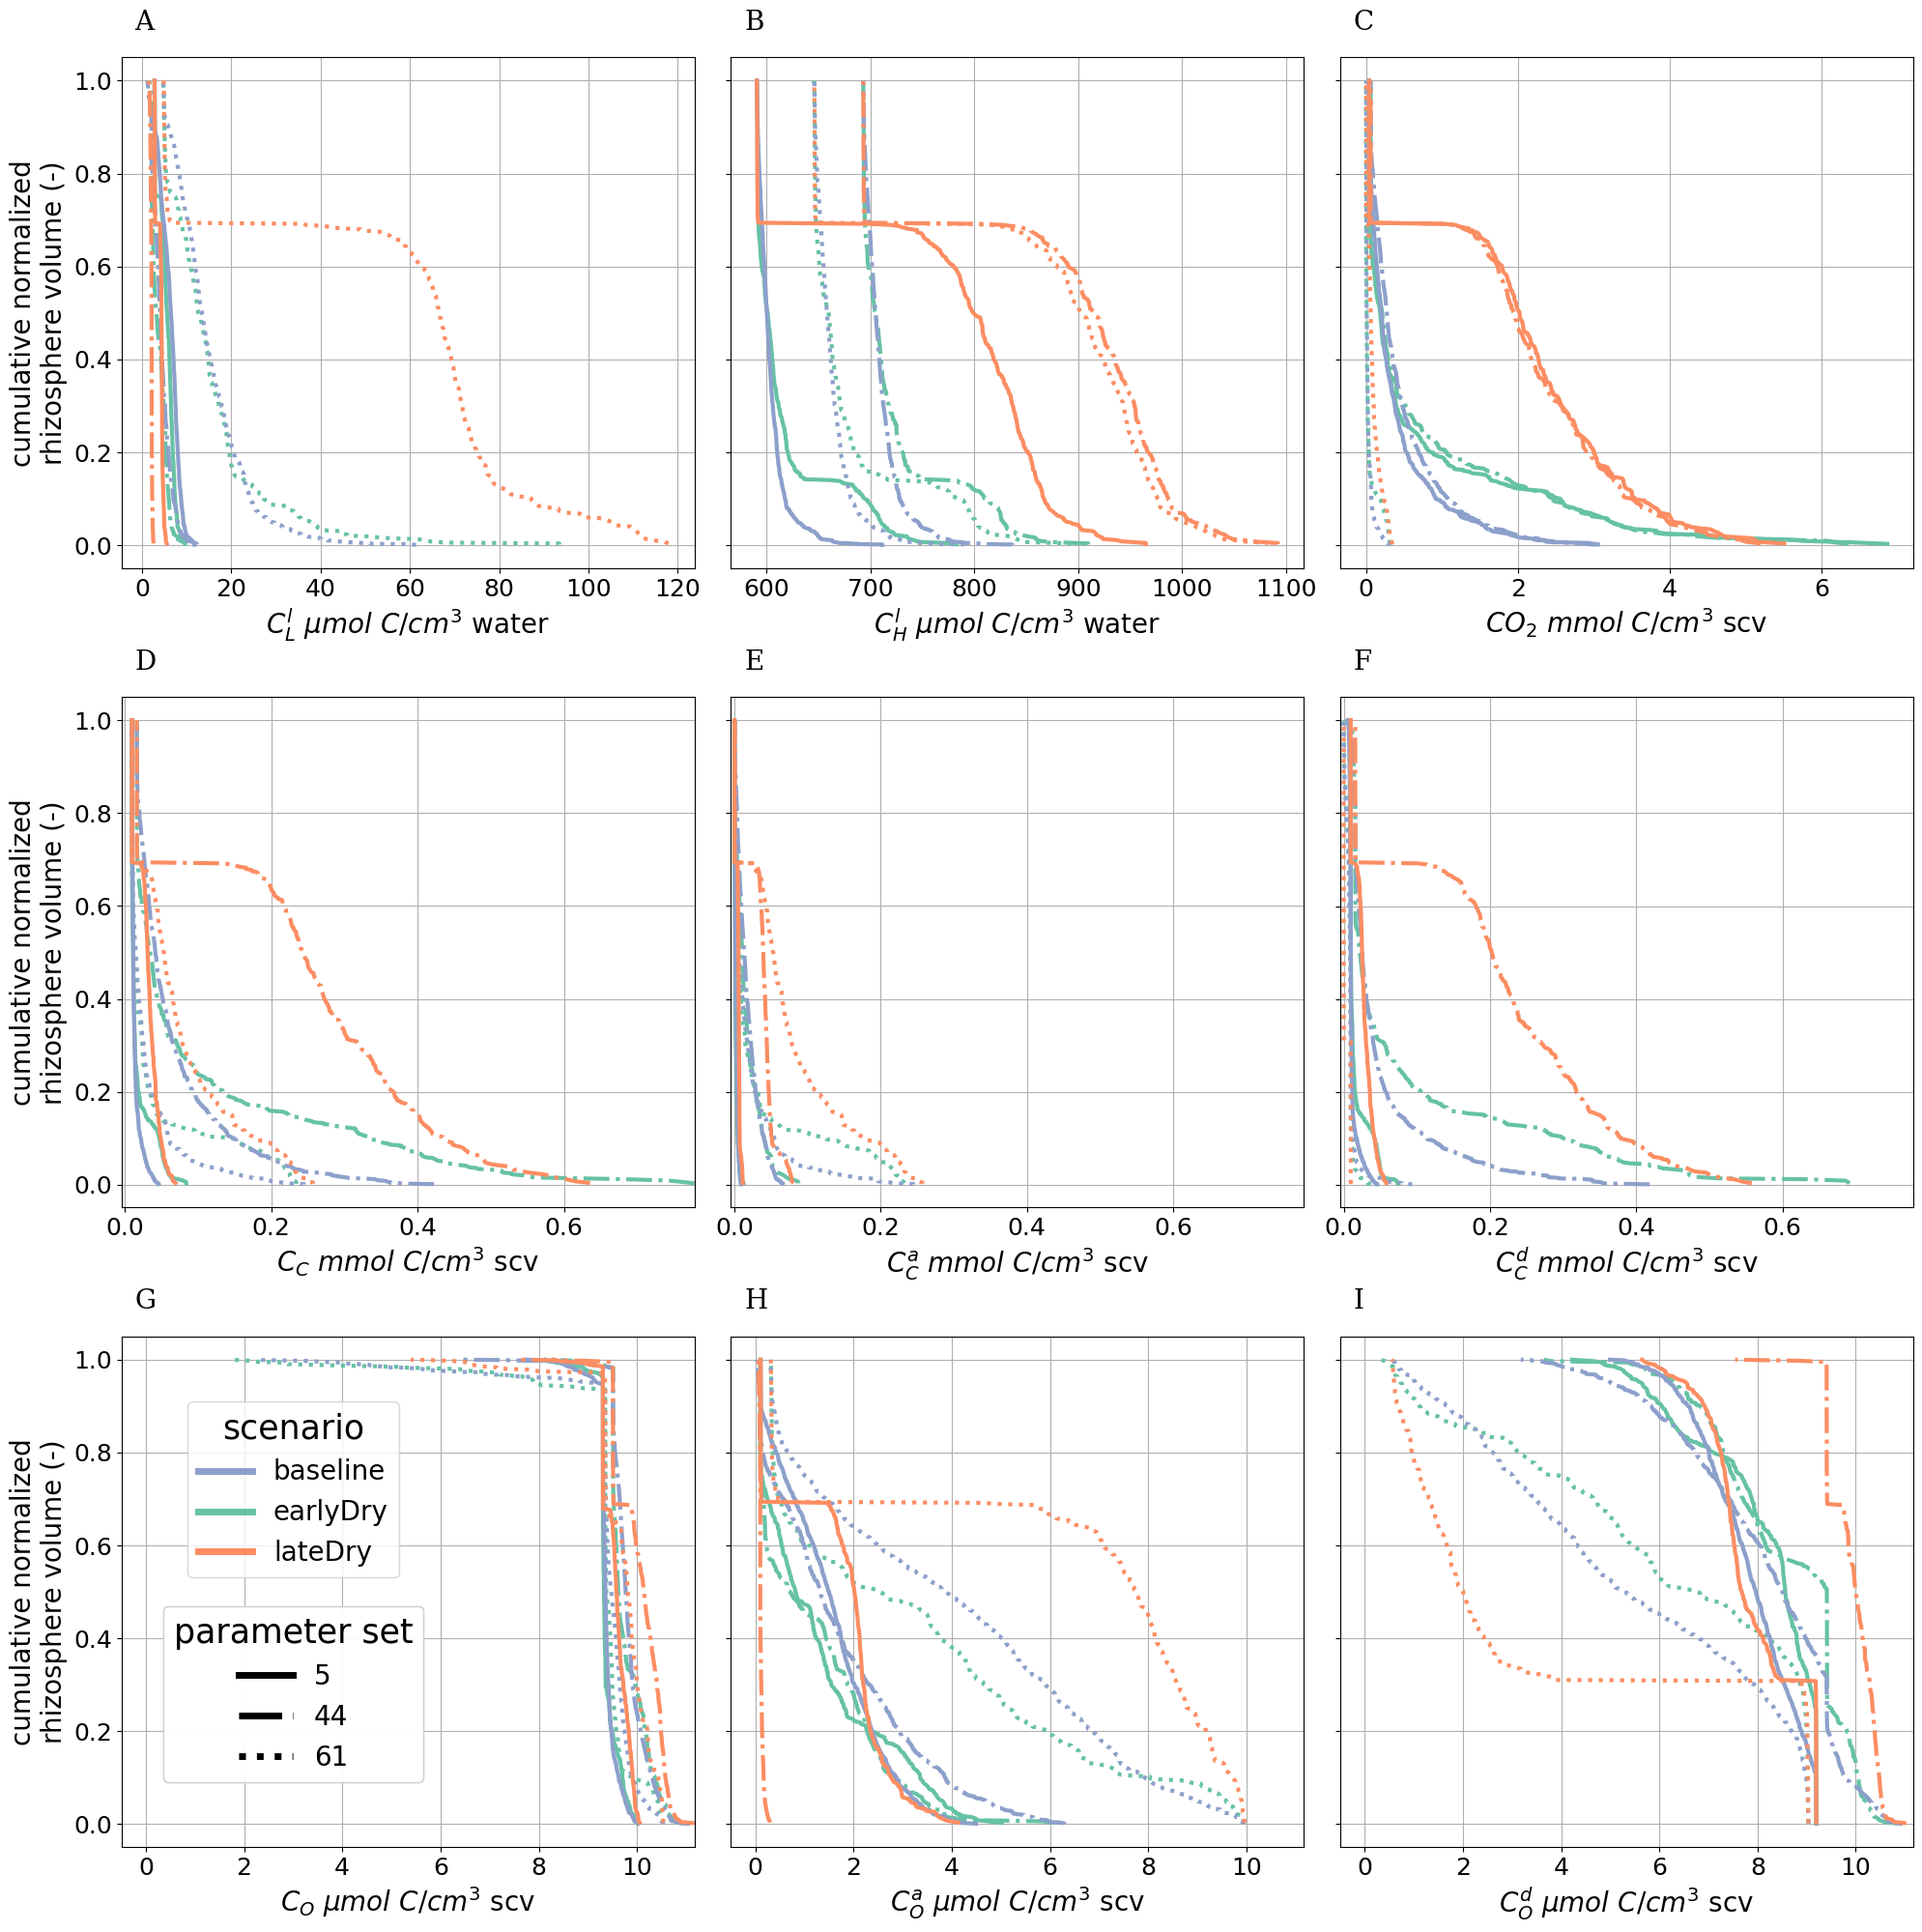

In [111]:
units ={'css': '$\mu mol~C/cm^3$ scv','co2': '$mmol~C/cm^3$ scv',
           'coa':  '$\mu mol~C/cm^3$ scv','cod':  '$\mu mol~C/cm^3$ scv',
        'co': '$\mu mol~C/cm^3$ scv' ,
           'cca':'$mmol~C/cm^3$ scv','ccd': '$mmol~C/cm^3$ scv','cc':'$mmol~C/cm^3$ scv',
           'cs':'$\mu mol~C/cm^3$ water','cl':'$\mu mol~C/cm^3$ water'} 

#['$\mu mol~C/cm^3$ water','$\mu mol~C/cm^3$ water',
#         '$\mu mol~C/cm^3$ soil','$\mu mol~C/cm^3$ soil',
#         '$\mu mol~C/cm^3$ soil','$\mu mol~C/cm^3$ soil',
#         '$\mu mol~C/cm^3$ soil','$\mu mol~C/cm^3$ soil',
#         '$\mu mol~C/cm^3$ soil','$\mu mol~C/cm^3$ soil']
unitChange={'css': 1e3,'co2': 1e3,
           'coa': 1e6,'cod': 1e6,'co':1e6 ,
           'cca':1e3,'ccd': 1e3,'cc':1e3,
           'cs':1e6,'cl':1e6}  
xlabels = {'css': '$C_L^s$','co2': '$CO_2$',
           'coa': '$C_O^a$','cod': '$C_O^d$',
           'cca': '$C_C^a$','ccd': '$C_C^d$',
           'cs': '$C_L^l$','cl':'$C_H^l$','cc': '$C_C$','co': '$C_O$' }  
xxx = ['cs', 'cl','co2',
       'cc','cca','ccd',
       'co','coa','cod']

xlims = [None, None, None, 
         xlimcc,xlimcc,xlimcc,
         xlimco,xlimco,xlimco,]
fig, axs = plt.subplots(3, 3, figsize=(20,20))
for indexsubplot in range(len(xxx)):
    ylab_ = 'cumulative normalized\nrhizosphere volume (-)' if indexsubplot not in  np.array([1,2,4,5,7,8]) else None
    cumsum_and_plot(dfmean, xxx[indexsubplot], 'vols',time=alltime[-1],
                ylab=ylab_, xlim=xlims[indexsubplot],doTitle=False,
                    unitChange=unitChange[xxx[indexsubplot]],
                    indexsubplotLegend=6,
                xlab=xlabels[xxx[indexsubplot]]+" "+units[xxx[indexsubplot]],
                    doLog=False, doshow = False, 
                dorelative=True,ascending=False, ax=axs.flat[indexsubplot], 
                    fig=fig,indexsubplot=indexsubplot, 
                   labelsnoYY = np.array([1,2,4,5,7,8]))
plt.tight_layout()  

plt.savefig('rhizoKonzPools.png')
plt.show()

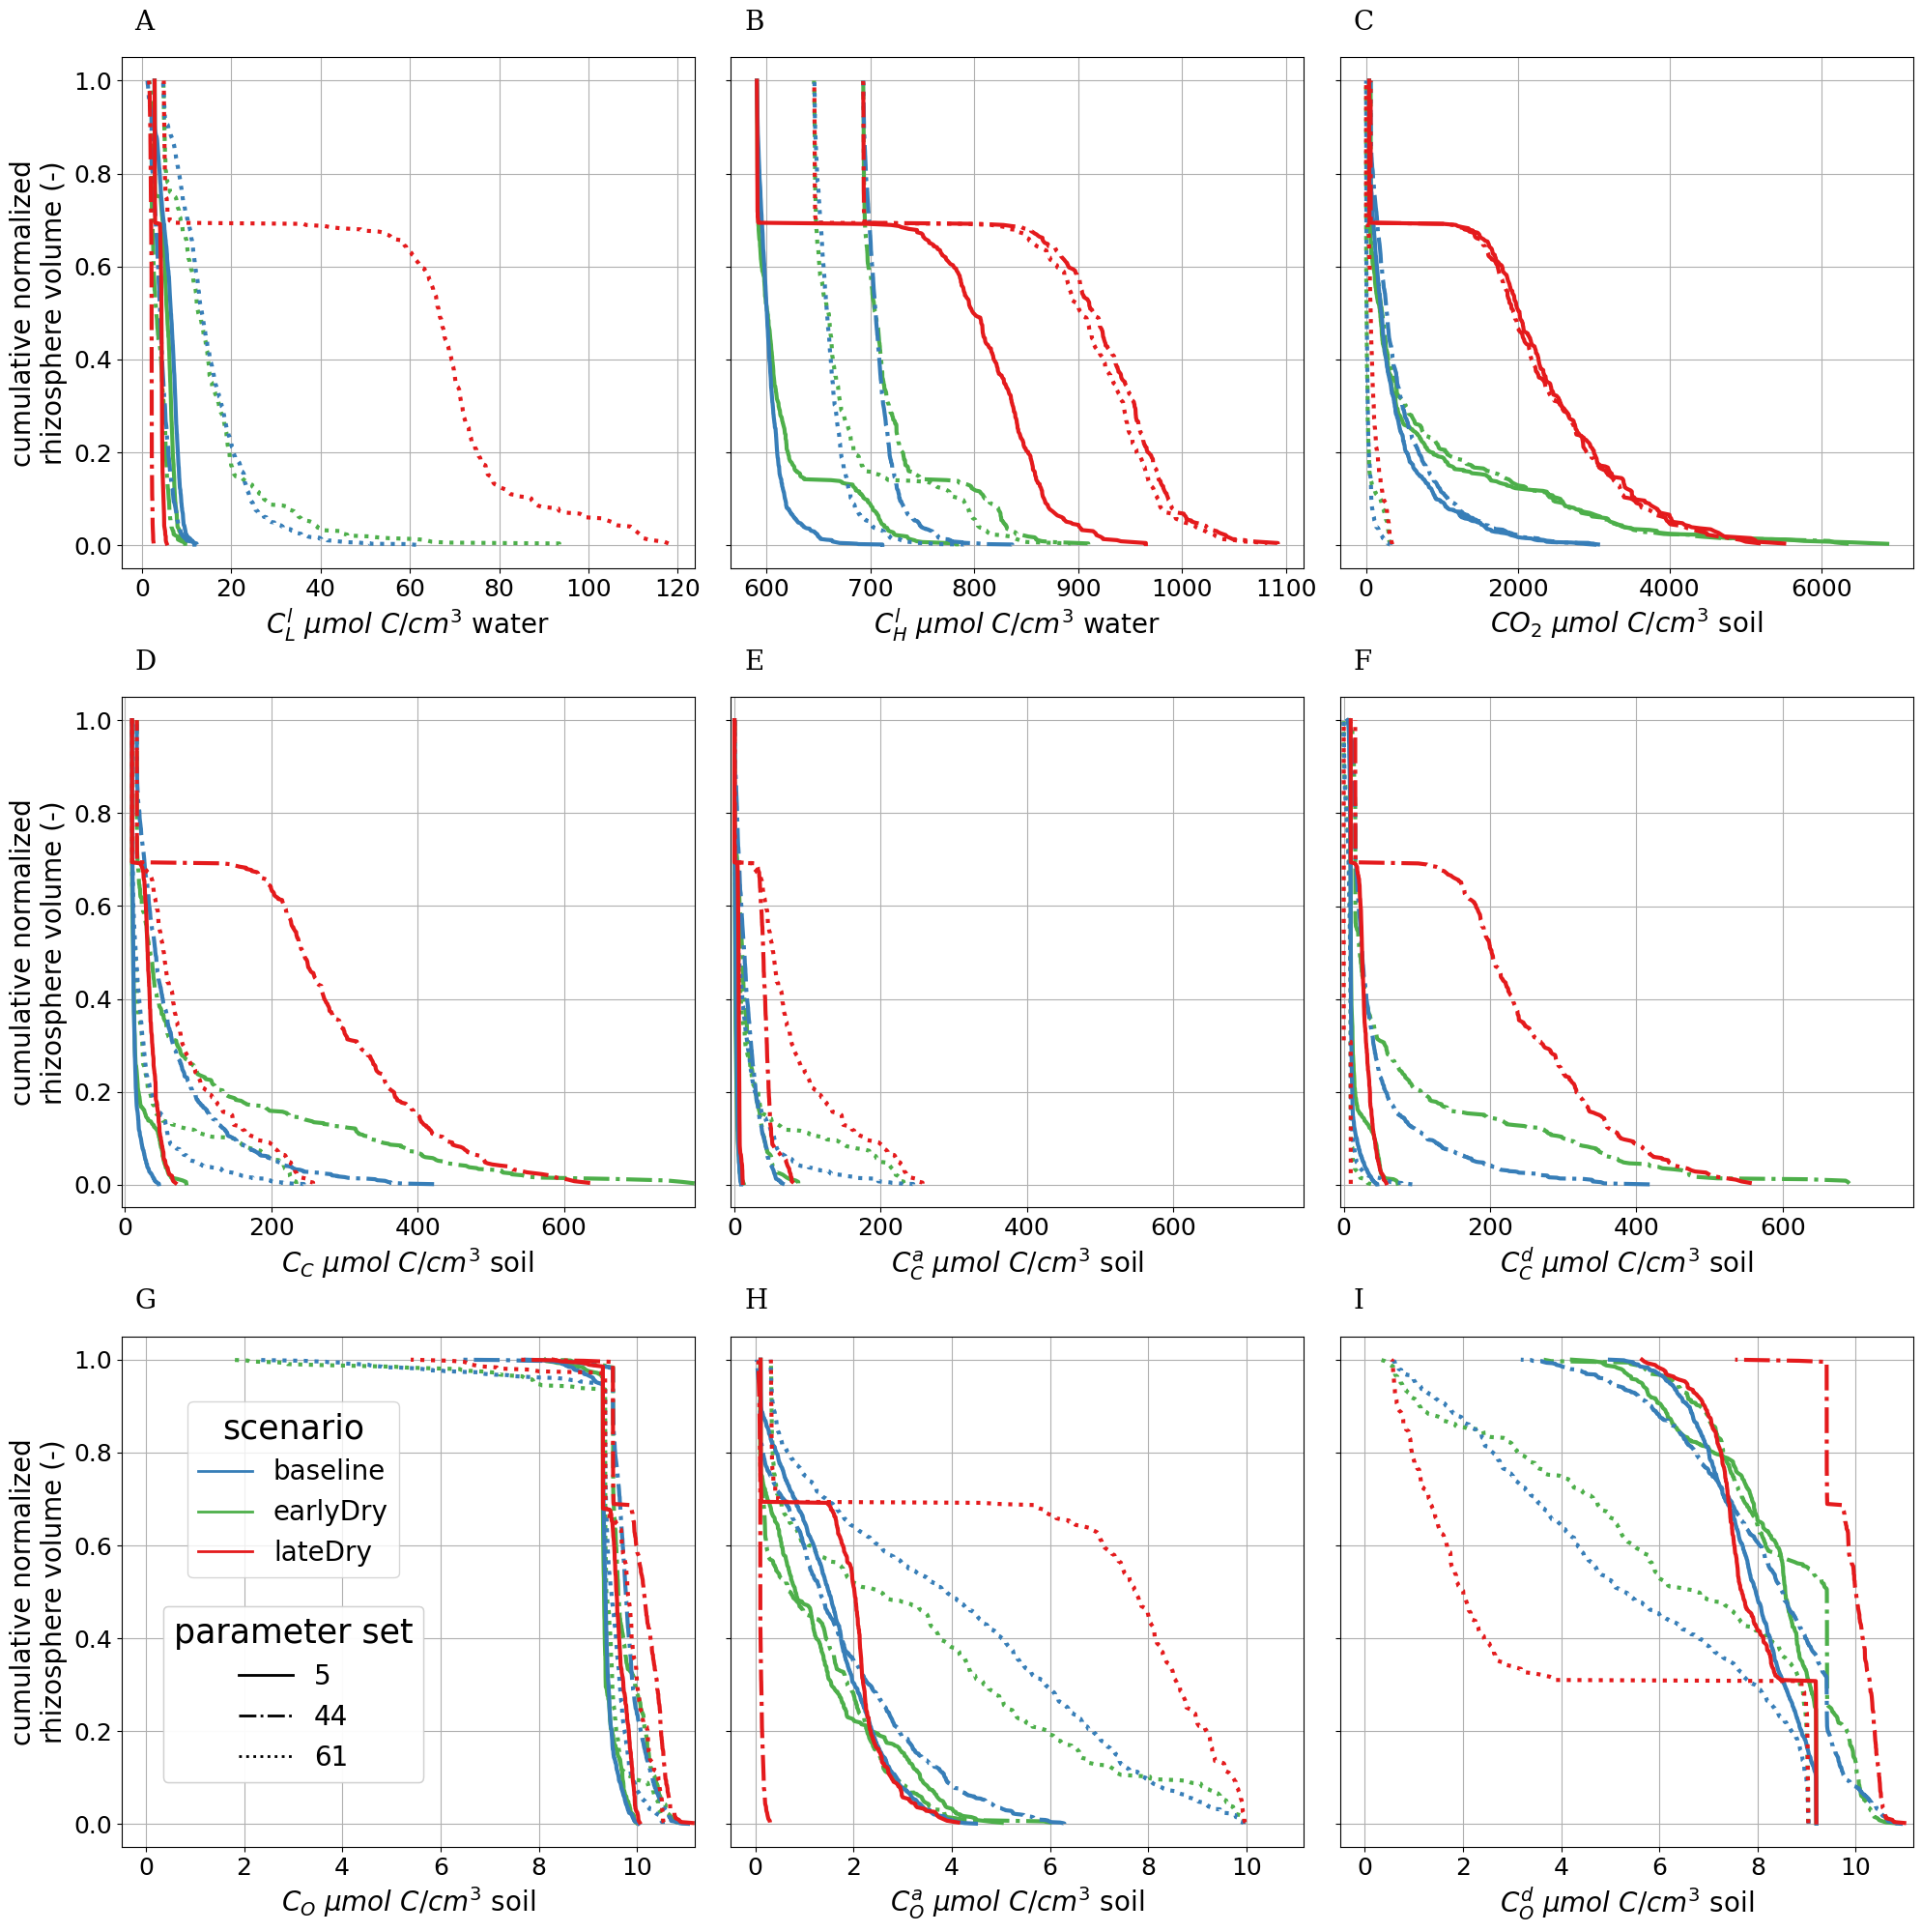

In [107]:
units = ['$\mu mol~C/cm^3$ water','$\mu mol~C/cm^3$ water',
         '$\mu mol~C/cm^3$ soil','$\mu mol~C/cm^3$ soil',
         '$\mu mol~C/cm^3$ soil','$\mu mol~C/cm^3$ soil',
         '$\mu mol~C/cm^3$ soil','$\mu mol~C/cm^3$ soil',
         '$\mu mol~C/cm^3$ soil','$\mu mol~C/cm^3$ soil']
xlabels = {'css': '$C_L^s$','co2': '$CO_2$',
           'coa': '$C_O^a$','cod': '$C_O^d$',
           'cca': '$C_C^a$','ccd': '$C_C^d$',
           'cs': '$C_L^l$','cl':'$C_H^l$','co2': '$CO_2$','cc': '$C_C$','co': '$C_O$' }  
xxx = ['cs', 'cl','co2',
       'cc','cca','ccd',
       'co','coa','cod']

xlims = [None, None, None, 
         xlimcc,xlimcc,xlimcc,
         xlimco,xlimco,xlimco,]
fig, axs = plt.subplots(3, 3, figsize=(20,20))
for indexsubplot in range(len(xxx)):
    ylab_ = 'cumulative normalized\nrhizosphere volume (-)' if indexsubplot not in  np.array([1,2,4,5,7,8]) else None
    cumsum_and_plot(dfmean, xxx[indexsubplot], 'vols',time=alltime[-1],
                ylab=ylab_, xlim=xlims[indexsubplot],unitChange=1e6,indexsubplotLegend=6,
                xlab=xlabels[xxx[indexsubplot]]+" "+units[indexsubplot],
                    doLog=False, doshow = False, doTitle=False,
                dorelative=True,ascending=False, ax=axs.flat[indexsubplot], 
                    fig=fig,indexsubplot=indexsubplot, 
                   labelsnoYY = np.array([1,2,4,5,7,8]))
plt.tight_layout()  

plt.savefig('rhizoKonzPools.png')
plt.show()

In [103]:
# for video
#print(SOCexp,classesSOC,SOCreal )

dateids_alltime = format_numbers_with_leading_zeros([dateid for dateid, date in enumerate(alltime)])

for dateid, ttt in enumerate(alltime): ##np.array([ i for i in range(10*24, 25*24+step, step)])/24):
    cumsum_and_plot(dfmean, 'socadapted', 'vols',time=ttt,
                    ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='maximum adapted SOC (mmol C/cm3 soil)',unitChange=1e3,
                    doLog=False, ascending=False, dorelative=True,
                    doshow=False, dosave=True,
                    savedir='./cumulRel/socadapted/',
                    saveName='soc'+dateids_alltime[dateid], 
                    commonLim = True, vlines = classesSOC,
                    ltypes_=['-','--','--','--'])
    

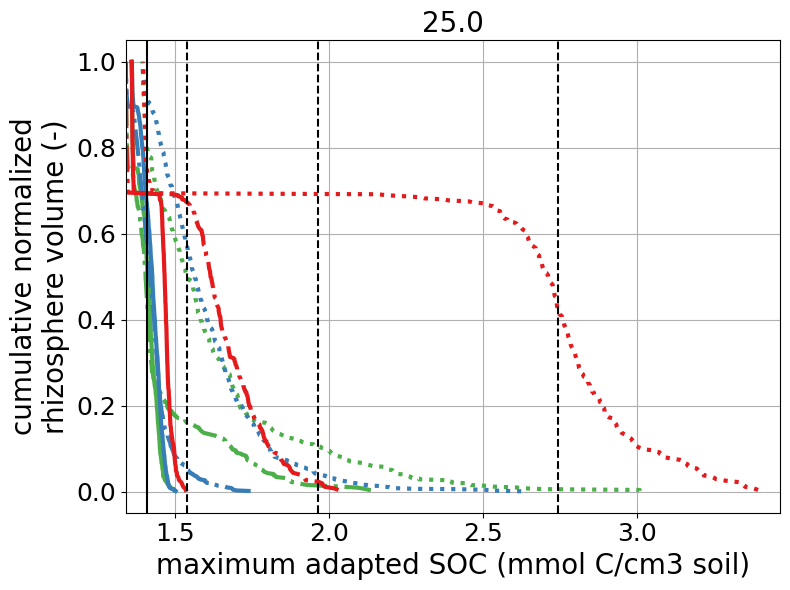

In [102]:
cumsum_and_plot(dfmean, 'socadapted', 'vols',time=alltime[-1],
                    ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='maximum adapted SOC (mmol C/cm3 soil)',unitChange=1e3,
                    doLog=False, ascending=False, dorelative=True,
                    doshow=True, dosave=False,
                    savedir='./cumulRel/socadapted/',
                    saveName='soc',#+dateids_alltime[dateid], 
                    commonLim = True, vlines = classesSOC,
                    ltypes_=['-','--','--','--'])

In [ ]:
step = 2

dateids_ = format_numbers_with_leading_zeros([dateid for dateid, date in enumerate(np.array([ i for i in range(10*24, 25*24+step, step)])/24)])
for dateid, date in enumerate(np.array([ i for i in range(10*24, 25*24+step, step)])/24):
    ttt=alltime[np.where(abs(alltime-date)== min(abs(alltime-date)))][0]
    cumsum_and_plot(dfmean, 'soc', 'vols',time=ttt,ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='max SOC (mol C/cm3 soil)',doLog=True, 
                ascending=False, dorelative=True, doshow=False, dosave=True,savedir='./cumulRel/LOC/',
                    saveName='LOC'+dateids_[dateid], commonLim = True)
    

In [310]:
step = 2

dateids_ = format_numbers_with_leading_zeros([dateid for dateid, date in enumerate(np.array([ i for i in range(10*24, 25*24+step, step)])/24)])
for dateid, date in enumerate(np.array([ i for i in range(10*24, 25*24+step, step)])/24):
    ttt=alltime[np.where(abs(alltime-date)== min(abs(alltime-date)))][0]
    cumsum_and_plot(dfmean, 'cs', 'vols',time=ttt,ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='max D-LMW-OC (mol C/cm3 water)',doLog=True, 
                ascending=False, dorelative=True, doshow=False, dosave=True,savedir='./cumulRel/LOC/',
                    saveName='LOC'+dateids_[dateid], commonLim = True)
    

In [311]:
step = 2

dateids_ = format_numbers_with_leading_zeros([dateid for dateid, date in enumerate(np.array([ i for i in range(10*24, 25*24+step, step)])/24)])
for dateid, date in enumerate(np.array([ i for i in range(10*24, 25*24+step, step)])/24):
    ttt=alltime[np.where(abs(alltime-date)== min(abs(alltime-date)))][0]
    cumsum_and_plot(dfmean, 'cl', 'vols',time=ttt,ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='max HMW-OC (mol C/cm3 water)',doLog=True, 
                ascending=False, dorelative=True, doshow=False, dosave=True,savedir='./cumulRel/HOC/',
                    saveName='HOC'+dateids_[dateid], commonLim = True)

In [ ]:
for dateid, date in enumerate(np.array([ i for i in range(10*24, 25*24+step, step)])/24):
    ttt=alltime[np.where(abs(alltime-date)== min(abs(alltime-date)))][0]
    
    cumsum_and_plot(dfmean, 'cc', 'vols',time=ttt,ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='maximum [copiotrophs] (mol C/cm3 soil)',doLog=False, ascending=False, dorelative=True,doshow=False, dosave=True,savedir='./cumulRel/CC/',
                    saveName='CC'+dateids_[dateid], commonLim = True)

In [ ]:
for dateid, date in enumerate(np.array([ i for i in range(10*24, 25*24+step, step)])/24):
    ttt=alltime[np.where(abs(alltime-date)== min(abs(alltime-date)))][0]
    cumsum_and_plot(dfmean, 'co', 'vols',time=ttt,ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='maximum [oligotrophes] (mol C/cm3 soil)',doLog=False, ascending=False, dorelative=True,doshow=False, dosave=True,savedir='./cumulRel/CC/',
                    saveName='CC'+dateids_[dateid], commonLim = True)

In [ ]:
for dateid, date in enumerate(np.array([ i for i in range(10*24, 25*24+step, step)])/24):
    ttt=alltime[np.where(abs(alltime-date)== min(abs(alltime-date)))][0]
    #print(ttt)
    cumsum_and_plot(dfmean, 'co2', 'vols',time=ttt,ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='maximum [CO2] (mol C/cm3 soil)',doLog=False, ascending=False, dorelative=True,doshow=False, dosave=True,savedir='./cumulRel/Co2/',
                    saveName='Co2'+dateids_[dateid], commonLim = True)

In [337]:
for dateid, date in enumerate(np.array([ i for i in range(10*24, 25*24+step, step)])/24):
    ttt=alltime[np.where(abs(alltime-date)== min(abs(alltime-date)))][0]
    #print(ttt)
    cumsum_and_plot(dfmean, 'soc', 'vols',time=ttt,ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='maximum SOC (mol C/cm3 soil)',doLog=False, ascending=False, dorelative=True,doshow=False, dosave=True,savedir='./cumulRel/soc/',
                    saveName='soc'+dateids_[dateid], commonLim = True, vlines = classesSOC, ltypes_=['-','--','--'])

German Agricultural
topsoils provided the new denominator with 
SOCexp [g/kg]= (clay[g/kg] × 0.0288 + 13.674)

In [397]:

dateids_alltime = format_numbers_with_leading_zeros([dateid for dateid, date in enumerate(alltime)])
maxcumulvol = sum(dfmean.loc[(dfmean['time']==max(dfmean['time']))&(dfmean['scenario']=='baseline')&(dfmean['pSet']=='5'),'vols'])
for dateid, ttt in enumerate(alltime): ##np.array([ i for i in range(10*24, 25*24+step, step)])/24):
    cumsum_and_plot(dfmean, 'socadapted', 'vols',time=ttt,ylab='cumulative\nrhizosphere volume (cm3)', 
                xlab='maximum adapted SOC (mol C/cm3 soil)',doLog=False, ascending=False, dorelative=False,doshow=False, dosave=True,savedir='./cumulAbs/socadapted/',
                    saveName='soc'+dateids_alltime[dateid], commonLim = True, vlines = classesSOC, ltypes_=['-','--','--','--'], maxYY = maxcumulvol)

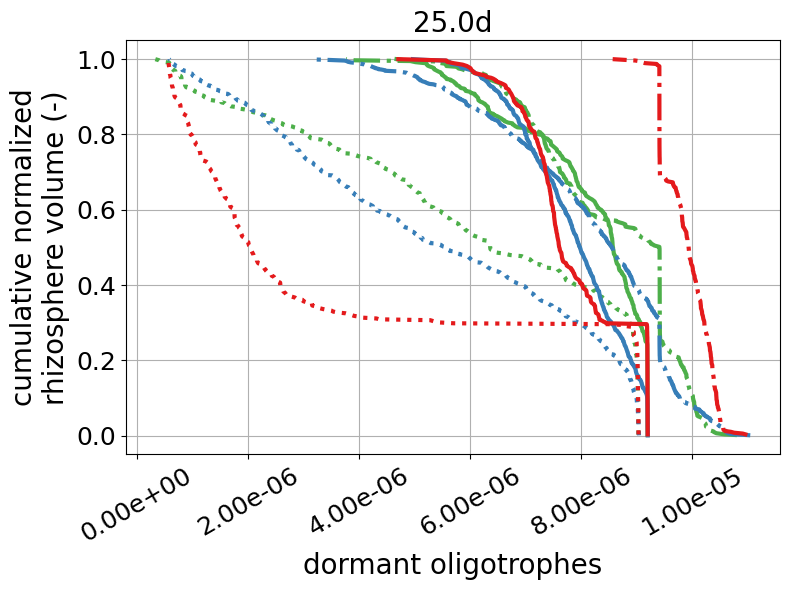

In [759]:
cumsum_and_plot(dfmean, 'cod', 'vols',time=alltime[-1],ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='dormant oligotrophes',doLog=False, dorelative=True,ascending=False)

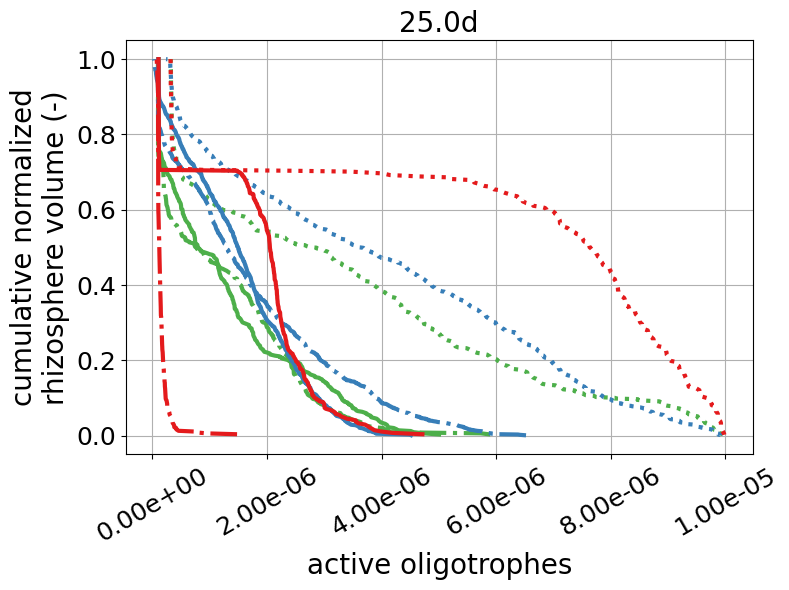

In [744]:
cumsum_and_plot(dfmean, 'coa', 'vols',time=alltime[-1],ylab='cumulative normalized\nrhizosphere volume (-)', 
                xlab='active oligotrophes',doLog=False, dorelative=True,ascending=False)

In [112]:
import string
def cumsumAll_(dataframe, orderVar,dependent_variable, independent_variable, ascending):
    dataframe.sort_values([orderVar], ascending=[ascending],inplace=True)
    dataframe['cumsum'] = np.cumsum(dataframe[independent_variable].values)
    return dataframe[[orderVar] +dependent_variable], dataframe['cumsum']

def cumsum_and_plotAll(dataframe_, orderVar,    depVars ,indepVar,time=-1,ylab=None, 
                       xlab=None,unitChange=1.,
                     dorelative=False,doLog=False, ascending=True,
                   dosave=False, doshow=True, savedir='./', saveName='myimage',
                       commonLim=False,
                   vlines=[], ltypes_=[], 
                       col4pset=False,
                       maxYY_ = None, minXX=None, vividlim=0, 
                       pSetscenarios=[],plotindexes=[], nrows=1, ncols=0,
                       legendLabel={},
                      sizerows=8,sizecols=6,colidLegend=0, rowidLegend=0):#min(dataframe_['socadded'])
    for extraText in [savedir]:
        if not os.path.exists(extraText):
            os.makedirs(extraText)

    addTitle = True
    if time < 0.:
        time = max(dataframe_['time'])
        addTitle = False
        
    dataframe = dataframe_[dataframe_['time']==time].reset_index().copy()

    # Loop for each subplot
    scenarios =np.array( ['baseline', 'earlyDry', 'lateDry'])
    pSets = np.array([5,44,61])
    
    if len(pSetscenarios) ==0:
        pSetscenarios = dataframe['pSetscenario'].unique()
        if col4pset:
            nrows = len(scenarios)
            ncols = len(pSets)
        else:
            ncols = len(scenarios)
            nrows = len(pSets)
        
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols)) 
    for psetScenario in pSetscenarios:
        
        df__ =dataframe[dataframe['pSetscenario']==psetScenario].copy().reset_index()

        rowid = np.where(int(df__['pSet'].unique()[0])==pSets)[0] 
        if ncols > 1:
            colid = np.where(df__['scenario'].unique()[0]==scenarios)[0] 
            if col4pset:
                rowid, colid = colid, rowid
            ax_ = ax[rowid, colid][0]
        else:
            colid = 0
            ax_ = ax[rowid]
        
        
        df_ = df__.groupby([orderVar]+depVars)[  indepVar].agg('sum').reset_index()
        bin_meansS, bin_sums = cumsumAll_(df_, orderVar,  depVars ,indepVar, ascending)
        vols_ =  bin_sums.values

        if dorelative:
            vols_ /= np.sum(df_['vols'])
            
        allcc = ['k','#8da0cb','#fc8d62','#66c2a5']#,'m','tab:olive','tab:gray','tab:pink']
        widths= [1,1,1,1,1,1,1,1]
        addedVals = np.zeros(vols_.shape)
        for vivid, vivi in enumerate(depVars):

            ax_.plot(bin_meansS[vivi].values*unitChange+addedVals,vols_,
                     linewidth=widths[vivid],
                             label=f'{legendLabel[vivi]}',
                             c=allcc[vivid],
                             #linestyle=l_styles[int(df__['pSet'].unique()[0])]
                    )
            if vivid > vividlim:
                ax_.fill_betweenx(vols_,addedVals,
                                  bin_meansS[vivi].values*unitChange+addedVals ,
                                  color=allcc[vivid])
            addedVals += bin_meansS[vivi].values*unitChange

        #plt.stackplot(vols_,bin_meansS[depVars].T.values,
        #         linewidth=3,colors=['k','b','g','c','m'])
        ax_.set_ylim(ymin=0.)

        if commonLim:
            
            maxXX =max(dataframe_[depVars].values.sum(axis=1))
            minXX =min(dataframe_[depVars].values.sum(axis=1))
            ax_.set_xlim(minXX*unitChange,maxXX*unitChange)
            if not dorelative:
                ax_.set_ylim(0,maxYY)        

        
        if (rowid==2) and (colid==1):
            ax_.set_xlabel(xlab, fontsize=20)#'maximum '+independent_variable+' (mol/cm3 water)')
        if (colid==0):
            if not col4pset:
                xlabdefault = "parameter set "+df__['pSet'].unique()[0]
            else:
                xlabdefault = df__['scenario'].unique()[0]
            if (rowid==1):
                ax_.set_ylabel(ylab+"\n"+xlabdefault, fontsize=20)
            else:
                ax_.set_ylabel("\n"+xlabdefault, fontsize=20)
                
                
        ax_.tick_params(axis='both', which='major', labelsize=18)
        #ax_.tick_params(axis='x', which='major', labelrotation=30, labelsize=18)
        
        label = string.ascii_uppercase[(rowid*ncols+colid)[0]]
        ax_.annotate(
                label,
                xy=(0, 1.15), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                fontsize='20', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

        for vid, vine in enumerate(vlines):
            ax_.axvline(x=vine, color='k', linestyle=ltypes_[vid])


        # Set x-axis to scientific format
        if False:
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((-2, 2))
            ax_.xaxis.set_major_formatter(formatter)
            ax_.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
            ax_.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2e}'))

        # Remove tick labels
        if rowid < 2:
            ax_.set_xticklabels([])
        if colid > 0:
            ax_.set_yticklabels([])
            
        ax_.grid(True)
        if (rowid==0):
            if col4pset:
                ylabdefault = "parameter set "+ df__['pSet'].unique()[0]
            else:
                ylabdefault = df__['scenario'].unique()[0]
            if ((colid == 1) or (ncols==1) ) and addTitle:
                ax_.set_title(str(int(time*10)/10)+ "d\n"+ylabdefault, fontsize=20)
            else:
                ax_.set_title("\n"+ylabdefault, fontsize=20)
        if doLog:
            ax_.set_xscale('log')
        if (colid == colidLegend) and (rowid==rowidLegend):
            # Create custom legend with thicker lines
            handles, labels = ax_.get_legend_handles_labels()
            thick_handles = [plt.Line2D([], [], color=handle.get_color(), linewidth=6) for handle in handles]
            ax_.legend(thick_handles, labels, fontsize=20,title_fontsize='25', title='microbial pool')
    plt.subplots_adjust(wspace=0.01, hspace=0.15)    
    #plt.tight_layout()  
    plt.grid(True)
    if dosave:
        plt.savefig(savedir+saveName+'.png', pad_inches=0.5)
    if doshow:
        plt.show()
    plt.close()

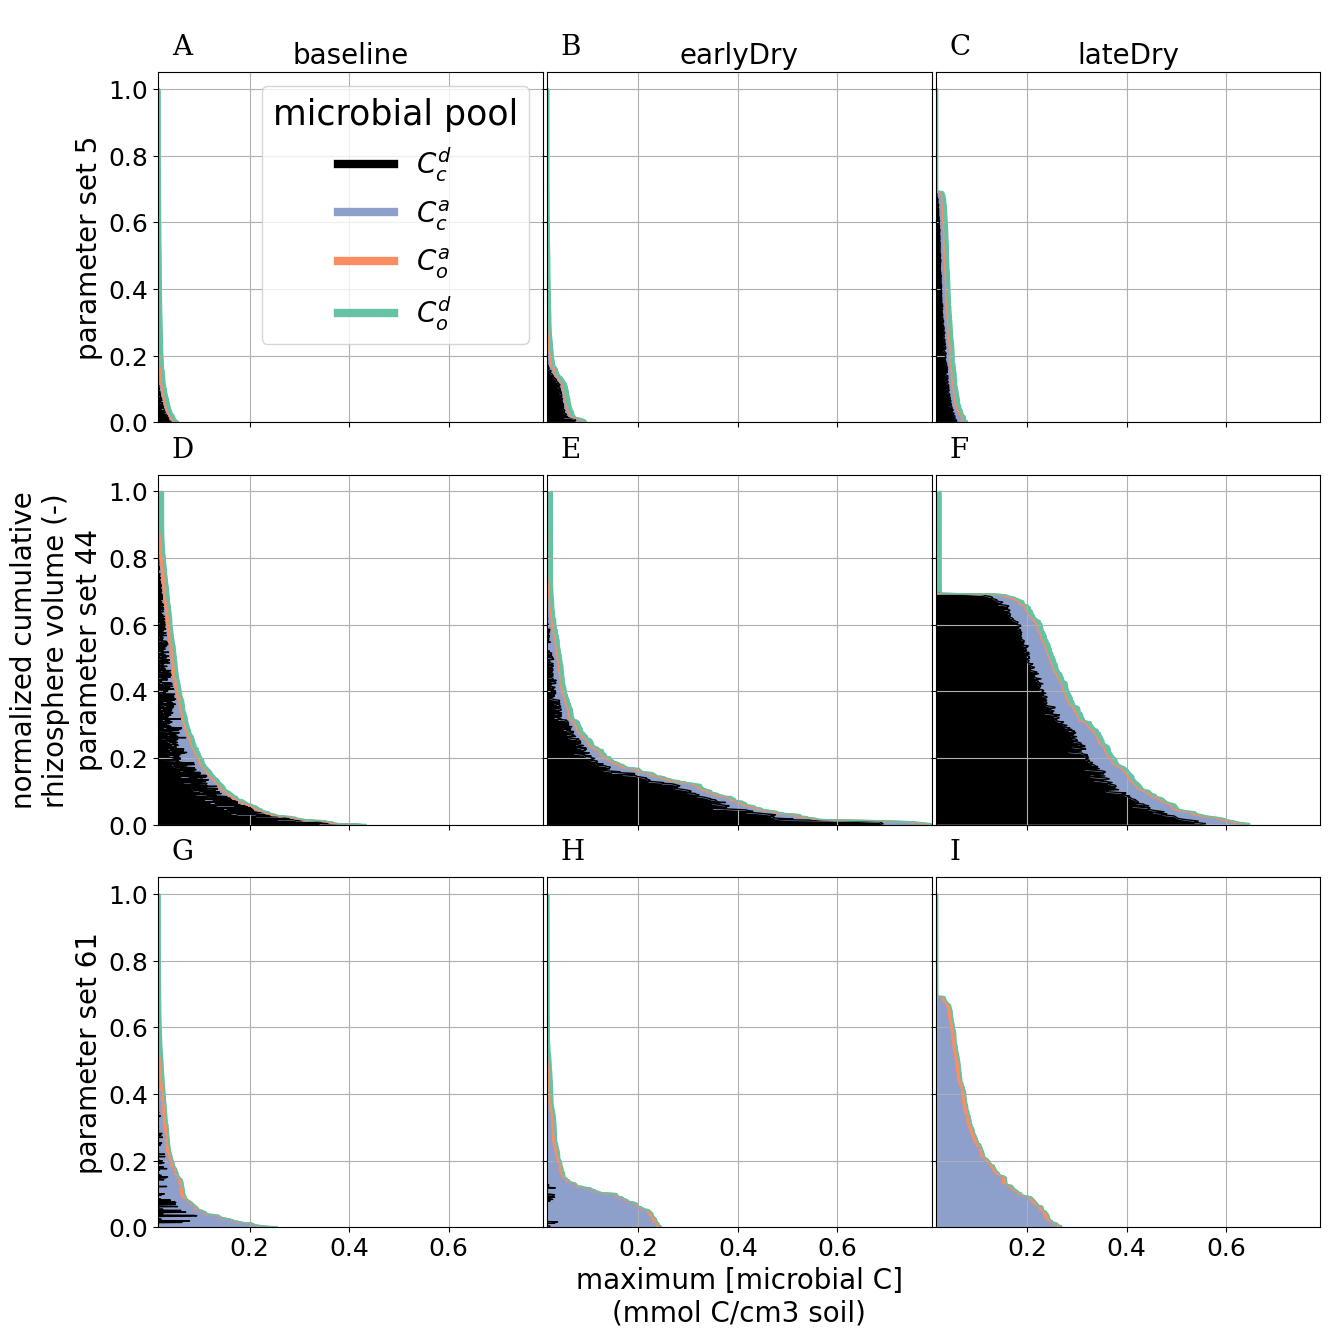

In [115]:
cumsum_and_plotAll(dfmean, 'cx',['ccd','cca','coa','cod'], 'vols',#time=ttt,
                       ylab='normalized cumulative\nrhizosphere volume (-)',
                       #'cumulative\nrhizosphere volume (cm3)', 
                xlab='maximum [microbial C]\n(mmol C/cm3 soil)',doLog=False,
                       dorelative=True,ascending=False,commonLim=True, 
                   pSetscenarios = [],vividlim=-1, 
                       col4pset=False,unitChange=1e3,
                       legendLabel = {'cod':"$C_o^d$",'coa':"$C_o^a$",
                                      'ccd':"$C_c^d$",'cca':"$C_c^a$"}
                   , sizerows=15,sizecols=15,doshow=True,
                       dosave=True,savedir='./',
                       saveName='CcadCoad_25'#+dateids_alltime[dateid]
                  )

In [104]:

dateids_alltime = format_numbers_with_leading_zeros([dateid for dateid, date in enumerate(alltime)])

for dateid, ttt in enumerate(alltime):
    cumsum_and_plotAll(dfmean, 'cx',['cod','ccd','coa','cca'], 'vols',time=ttt,
                       ylab='normalized cumulative\nrhizosphere volume (-)',
                       #'cumulative\nrhizosphere volume (cm3)', 
                xlab='maximum [microbial C]\n(mmol C/cm3 soil)',doLog=False,
                       dorelative=True,ascending=False,commonLim=True, 
                   pSetscenarios = [],vividlim=-1, 
                       col4pset=False,unitChange=1e3,
                       legendLabel = {'cod':"$C_o^d$",'coa':"$C_o^a$",
                                      'ccd':"$C_c^d$",'cca':"$C_c^a$"}
                   , sizerows=15,sizecols=15,doshow=False,
                       dosave=True,savedir='./cumulRel/cx/',
                       saveName='cx'+dateids_alltime[dateid]
                  )
    

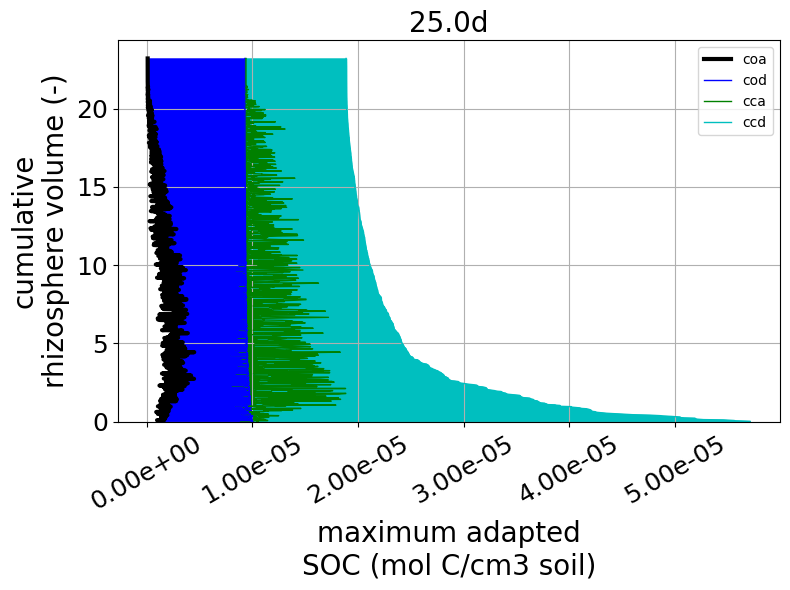

In [615]:
cumsum_and_plotAll(dfmean, 'cx',['coa','cod','cca','ccd'], 'vols',time=alltime[-1],ylab='cumulative\nrhizosphere volume (-)', 
                xlab='maximum adapted\nSOC (mol C/cm3 soil)',doLog=False, dorelative=False,ascending=False,commonLim=False, 
                   psetScenario = '5baseline'#dataframe['pSetscenario'].unique()[0], 
                   #,vlines = classesSOC, ltypes_=['-','--','--','--']
                  )

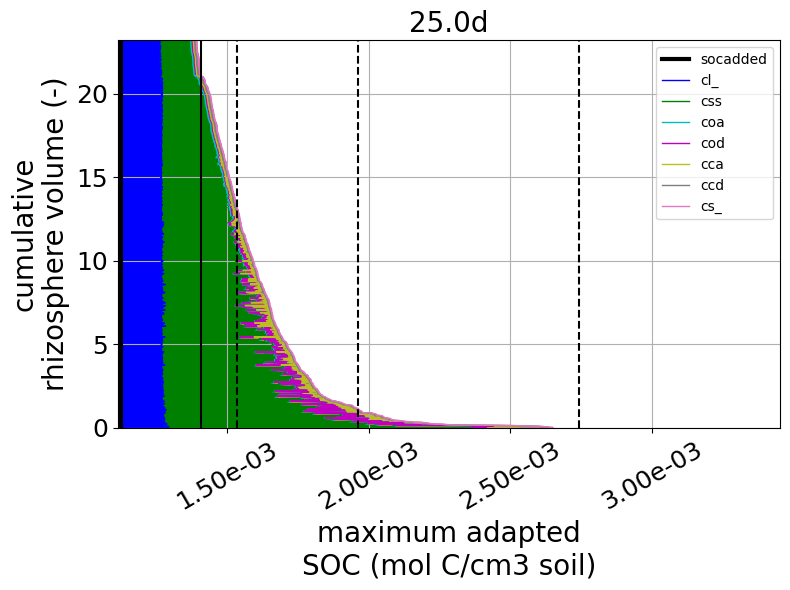

In [611]:
cumsum_and_plotAll(dfmean, 'socadapted',['socadded','cl_','css','coa','cod','cca','ccd', 'cs_'], 'vols',time=alltime[-1],ylab='cumulative\nrhizosphere volume (-)', 
                xlab='maximum adapted\nSOC (mol C/cm3 soil)',doLog=False, dorelative=False,ascending=False,commonLim=True, 
                   psetScenario = '61baseline',#dataframe['pSetscenario'].unique()[0], 
                   vlines = classesSOC, ltypes_=['-','--','--','--'])

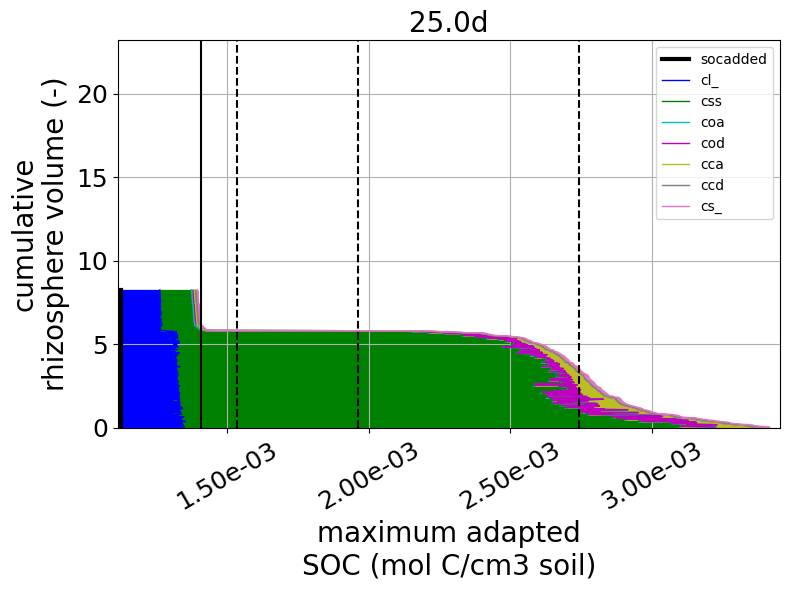

In [610]:
cumsum_and_plotAll(dfmean, 'socadapted',['socadded','cl_','css','coa','cod','cca','ccd', 'cs_'], 'vols',time=alltime[-1],ylab='cumulative\nrhizosphere volume (-)', 
                xlab='maximum adapted\nSOC (mol C/cm3 soil)',doLog=False, dorelative=False,ascending=False,commonLim=True, 
                   psetScenario = '61lateDry',#dataframe['pSetscenario'].unique()[0], 
                   vlines = classesSOC, ltypes_=['-','--','--','--'])

In [561]:

def cumsumAll_(dataframe, orderVar,dependent_variable, independent_variable, ascending):
    dataframe.sort_values([orderVar], ascending=[ascending],inplace=True)
    dataframe['cumsum'] = np.cumsum(dataframe[independent_variable].values)
    return dataframe[[orderVar] +dependent_variable], dataframe['cumsum']
def cumsum_and_plotAll(dataframe_, orderVar,    depVars ,indepVar,time,ylab=None, xlab=None,
                     dorelative=False,doLog=False, ascending=True,
                   dosave=False, doshow=True, savedir='./', saveName='myimage',commonLim=False,
                   vlines=[], ltypes_=[], maxYY_ = None, psetScenario = None):
    for extraText in [savedir]:
        if not os.path.exists(extraText):
            os.makedirs(extraText)

    # Create the plot
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    dataframe = dataframe_[dataframe_['time']==time].reset_index().copy()

    # Loop to plot each line
    df__ =dataframe[dataframe['pSetscenario']==psetScenario].copy().reset_index()
    df_ = df__.groupby([orderVar]+depVars)[  indepVar].agg('sum').reset_index()
    bin_meansS, bin_sums = cumsumAll_(df_, orderVar,  depVars ,indepVar, ascending)
    vols_ =  bin_sums.values

    if dorelative:
        vols_ /= np.sum(df_['vols'])

    plt.stackplot(vols_,bin_meansS[depVars].T.values,
             linewidth=3,colors=['k','b','g','c','m'])
    plt.xlim(left=0.)
    if commonLim:
        plt.ylim(min(dataframe_[depVars].values.sum(axis=1)),max(dataframe_[depVars].values.sum(axis=1)))
        if not dorelative:
            minYY = 0
            maxYY = maxYY_
            plt.xlim(minYY,maxYY_)
            
        

    plt.xlabel(xlab, fontsize=20)#'maximum '+independent_variable+' (mol/cm3 water)')
    plt.ylabel(ylab, fontsize=20)
    plt.gca().tick_params(axis='both', which='major', labelsize=18)
    plt.gca().tick_params(axis='y', which='major', labelrotation=30, labelsize=18)
    
    for vid, vine in enumerate(vlines):
        plt.gca().axhline(y=vine, color='k', linestyle=ltypes_[vid])
        
    
    # Set x-axis to scientific format
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2e}'))
    plt.title(str(int(time*10)/10)+ "d", fontsize=20)
    if doLog:
        plt.yscale('log')
    #plt.legend()
    if False:
        plt.legend(handles=color_legend_elements, 
                                                               fontsize=20,title_fontsize='25', title='scenario', 
                                                               loc='upper left',  ncol=3)
        plt.legend(handles=linestyle_legend_elements, 
                                                               fontsize=20,title_fontsize='25', title='parameter set', 
                                                               loc='upper left',  ncol=3)
        plt.gca().add_artist(plt.legend(handles=color_legend_elements, 
                                                                                  fontsize=20, title='scenario', 
                                                                                   title_fontsize='25',
                                                                                  loc='upper right',# bbox_to_anchor=anchor1,#(0.5, -0.15), 
                                                                                  ncol=3, framealpha=1))
        plt.gca().add_artist(plt.legend(handles=linestyle_legend_elements, 
                                                                                  fontsize=20, title='parameter set', 
                                                                                   title_fontsize='25',
                                                                                  loc='upper center',# bbox_to_anchor=anchor2,#(0.5, -0.3), 
                                                                                ncol=3, framealpha=1))
    plt.tight_layout()  
    plt.grid(True)
    if dosave:
        plt.savefig(savedir+saveName+'.png', pad_inches=0.5)
    if doshow:
        plt.show()
    plt.close()

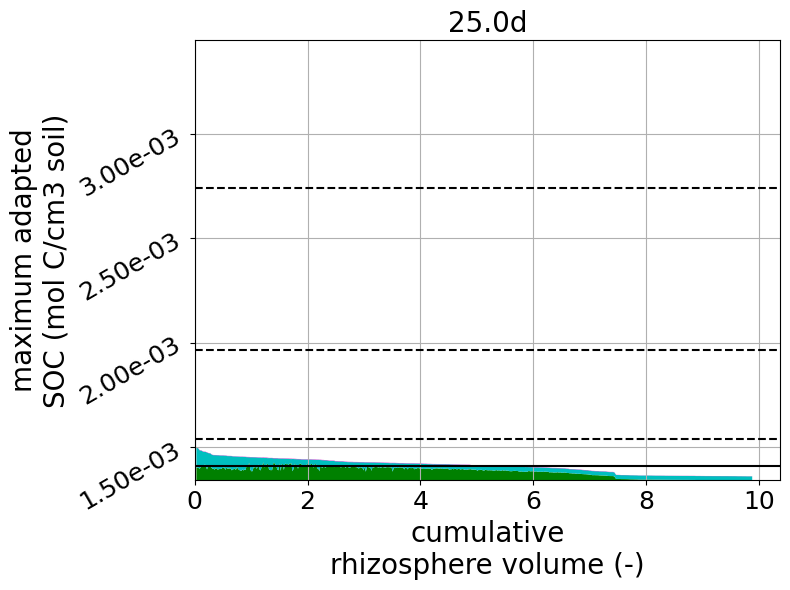

In [563]:
cumsum_and_plotAll(dfmean, 'socadapted',['socadded','cl_','css','cx','cs_'], 'vols',time=alltime[-1],xlab='cumulative\nrhizosphere volume (-)', 
                ylab='maximum adapted\nSOC (mol C/cm3 soil)',doLog=False, dorelative=False,ascending=False,commonLim=True, psetScenario = dataframe['pSetscenario'].unique()[0], 
                   vlines = classesSOC, ltypes_=['-','--','--','--'])

In [556]:
bin_meansS

,socadapted,socinit,cl_,css,cx,cs_
456,0.001498,0.000262,0.000160,0.000094,0.000096,1.210717e-06
455,0.001493,0.000262,0.000159,0.000093,0.000093,1.226733e-06
454,0.001483,0.000262,0.000158,0.000089,0.000088,1.214427e-06
453,0.001482,0.000262,0.000162,0.000100,0.000072,1.281241e-06
452,0.001477,0.000262,0.000161,0.000099,0.000069,1.306288e-06
...,...,...,...,...,...,...
4,0.001358,0.000262,0.000127,0.000065,0.000019,6.059835e-07
3,0.001358,0.000262,0.000126,0.000066,0.000019,6.063552e-07
2,0.001358,0.000262,0.000126,0.000066,0.000019,6.063552e-07
1,0.001358,0.000262,0.000126,0.000066,0.000019,6.063551e-07


In [557]:
bin_meansS[['socinit','cl_','css','cx','cs_']].sum(axis=1)

456    0.000613
455    0.000608
454    0.000598
453    0.000597
452    0.000592
         ...   
4      0.000473
3      0.000473
2      0.000473
1      0.000473
0      0.000473
Length: 457, dtype: float64

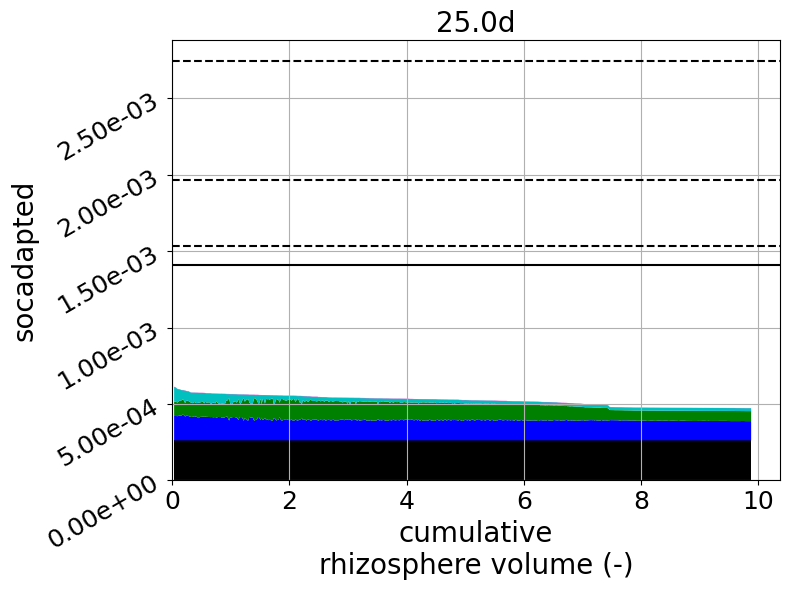

In [546]:

cumsum_and_plotAll(dfmean, 'socadapted',['socinit','cl_','css','cx','cs_'], 'vols',time=alltime[-1],xlab='cumulative\nrhizosphere volume (-)', 
                ylab='socadapted',doLog=False, dorelative=False,ascending=False,commonLim=False, psetScenario = dataframe['pSetscenario'].unique()[0], 
                   vlines = classesSOC, ltypes_=['-','--','--','--'])

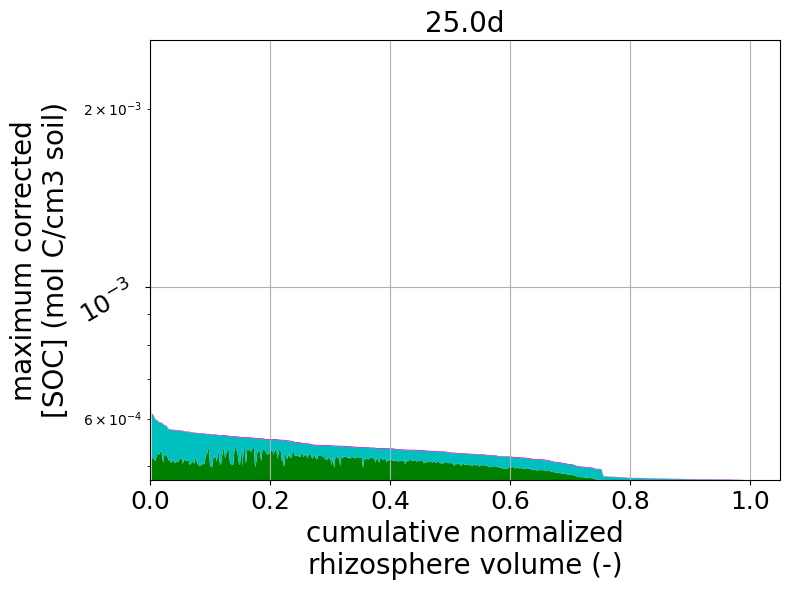

In [538]:

cumsum_and_plotAll(dfmean, 'socadapted',['socinit','cl_','css','cx','cs_'], 'vols',time=alltime[-1],xlab='cumulative normalized\nrhizosphere volume (-)', 
                ylab='maximum corrected\n[SOC] (mol C/cm3 soil)',doLog=True, dorelative=True,ascending=False,commonLim=True, psetScenario = dataframe['pSetscenario'].unique()[0])